<a href="https://colab.research.google.com/github/lukaszszydlowski/digit-recognizer/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [ ]:
input_path = '/content/drive/MyDrive/Colab/Digit Recognizer/input'
output_path = '/content/drive/MyDrive/Colab/Digit Recognizer/output'

In [ ]:
traing_data = pd.read_csv(input_path + 'train.csv')    
test_data = pd.read_csv(input_path + 'test.csv') 

In [ ]:
def format_data(data):
  has_labels = 'label' in data.columns

  if has_labels:
    labels = data['label'].to_numpy(dtype='int')
    images = data.iloc[:, 1:786].to_numpy(dtype='float64')
  else:
    labels = None
    images = data.iloc[:, :785].to_numpy(dtype='float64')

  n = images.shape[0]
  images = np.reshape(images, (n, 28, 28, 1))  
  
  return images, labels

In [ ]:
def plot_categories(training_images, training_labels = None, count = 10):
  fig, axes = plt.subplots(1, count, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)
  indexes = random.choices(range(0, training_images.shape[0]), k=count)

  for i in range(count):
    k = indexes[i]
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[i]
    ax.imshow(img, cmap="Greys_r")
    if training_labels is not None:
      ax.set_title(f"{training_labels[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [ ]:
training_images, training_labels = format_data(traing_data)
test_images, test_labels = format_data(test_data)

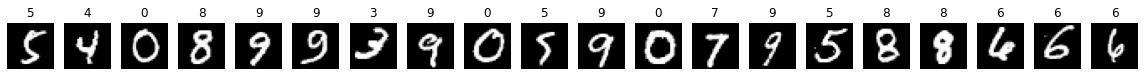

In [ ]:
plot_categories(training_images, training_labels, 20)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
training_generator = datagen.flow(x=training_images, y=training_labels, batch_size=32, subset='training')
validation_generator = datagen.flow(x=training_images, y=training_labels, batch_size=32, subset='validation')

test_images = test_images / 255.0

In [ ]:
def conv_block(x, filters, dropout=0.2):
  x = tf.keras.layers.Conv2D(filters, (3,3), activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(2, 2)(x)
  x = tf.keras.layers.Dropout(dropout)(x)

  return x

In [ ]:
def classifier_block(x):
  x = tf.keras.layers.Flatten()(x) 
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='softmax')(x)

  return x

In [ ]:
def get_model():
  input = tf.keras.layers.Input((28, 28, 1))
  x = conv_block(input, 32, dropout=0.35)
  x = conv_block(x, 64, dropout=0.35)
  x = classifier_block(x)

  model = tf.keras.models.Model(inputs=[input], outputs=[x])
  return model

In [ ]:
model = get_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                      

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
history = model.fit(training_generator, epochs=20, validation_data=validation_generator, verbose=1)

Epoch 1/20
1050/1050 [==============================] - 9s 8ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.0236 - val_sparse_categorical_accuracy: 0.9929
Epoch 2/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0208 - val_sparse_categorical_accuracy: 0.9938
Epoch 3/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0200 - val_sparse_categorical_accuracy: 0.9946
Epoch 4/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0173 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0254 - val_sparse_categorical_accuracy: 0.9938
Epoch 5/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0297 - val_sparse_categorical_accuracy: 0.9926
Epoch 6/20
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0139 - spars

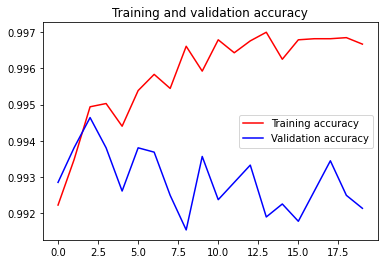

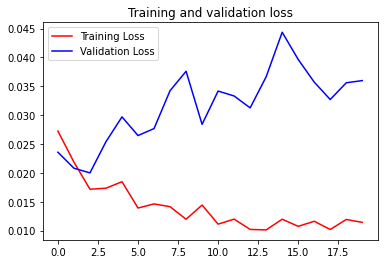

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(validation_generator)

263/263 [==============================] - 1s 4ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9921


[0.035977598279714584, 0.9921428561210632]

In [ ]:
test_result = model.predict(test_images)
test_result = np.argmax(test_result, axis=-1)

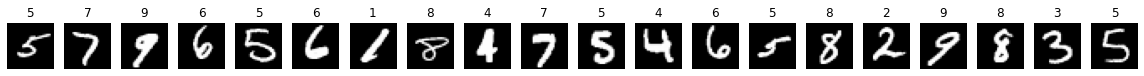

In [ ]:

plot_categories(test_images, test_result, 20)

In [ ]:
image_ids = pd.Series(range(1, test_result.shape[0] + 1), name='ImageId')
labels = pd.Series(test_result, name='Label')
output_data = pd.concat([image_ids, labels], axis=1)

,index,ImageId,Label
0,0,1,2
1,1,2,0
2,2,3,9
3,3,4,0
4,4,5,3
...,...,...,...
27995,27995,27996,9
27996,27996,27997,7
27997,27997,27998,3
27998,27998,27999,9


In [ ]:
output_data.to_csv(output_path + 'submission.csv', index=False)